# Nonlinear Regression

in the last lecture and exercise, we have seen that curve fitting allows us to:
- make predictions (extrapolation and interpolation)
- summarize our data through parameters
- quantify complex changes in our data after a treatment.

Why is linear regression not enough? The relation between manipulated and observable variables are often not linear!

- For instance, biological variables like firing rates or concentrations often have minimal (often 0) and maximal values: We can fit a sigmoidal function to the intensity curves on the right. Removing inhibition increases the steepness of the curve (the slope parameter) from 10 to 20, and makes the cell more sensitive - it shifts the curve to the left with a midpoint (intensity at which 50 of the maximal response is elicited) from 50 to 30 dB. The maximal response rate does not change.
- Or they have optimum-like curves, where a single value gives a maximal response: We can fit Gaussians to the tuning curves on the left. The mean parameter specifies the preferred orientation (the position of the peak) - it is 115, 160 and 206 degrees. The standard deviation parameters corresponds to the width. It identical for all three cells at 115 degrees.

![](fig/6.01_curve_fitting_1d.png)

Nonlinear regression is more powerful than linear regression, since we can freely specify the relationship in our data. But this power makes it also more complicated.

## Nonlinear regression
So how does nonlinear regression work in python?

We need these three ingredients:
1. A model: Specify an adequate _equation_ that has the potential to describe our data with an appropriate choice of _parameters_. A line cannot describe the curved relationship between temperature and pain in the plot above - there is no set of slopes and interecepts that produces a curve from a linear equation. So we need something more complicated, like a quadratic equation. Whereas the model was fixed to a line, in nonlinear regression, __we need to specify the equation in a python function__.
2. A way to improve the fit and a measure of goodness of fit: A _fitting procedure_ to adjust the equation's parameters so that the resulting line or curve fits our data best - is "as close as possible" to our data. __We will use so called "least-squares" fitting__, which minimizes the mean-squared error of between the data and the model predictions.
3. A way to quantify the "goodness of fit": An _error function_ or _objective function_ that tells us how good the fit between the experimental data points and the curve produced by the function is, so we can adjust the parameters to maximize the fit. As in linear regression, __we will use the coefficient of determination__, which quantifies how much of the variance in data is captured by the model.

### The model
The function determines the type of relationship you can capture in your data:
- linear functions capture linear relationships (see above): $y=\text{slope} * x + \text{intercept}$
- exponential functions capture exponential growth or decay: $y=\text{baseline}+\text{gain}*e^{-x/\tau}$
- quadratic functions capture parabolic relationships (also see above): $y=a+bx+cx^2$
- sigmoidal functions capture sigmoidal relationships: $y=\text{baseline} + \frac{\text{gain}}{1 + e^{(-\text{slope}(x - \text{midpoint}))}}$

Here is an example of what the different parametes of the sigmoidal (Boltzmann) function do:

![](fig/6.01_curve_fitting_1f.png)

There exist "universal function approximators", that can capture any relationship in your data:
- Polynomial functions are sums of polynomials of increasing degrees (a generalization of the quadratic equation to higher exponents). With sufficient degree, they can approximate any function (Taylor expansion), : $y = w_0 + w_1x + _w2x^2 + w_3x^3 ... = \sum_i w_i x^i$
- Fourier series are sums of sines and cosines of increasing frequencies. They can also approximate any (periodic) function: $y = w_0 + \sum_n w_n sin(nx) + v_i cos(nx)$

However, the flexibility of these "universal function approximators" comes at the cost of potentially many, barely interpretable parameters. It is therefore better to try and find a simple equation that matches your problem.

Let's load some data to have an example to work through:

We've stressed an animal by exposing them to Ornette Coleman and want to quantify how quickly cortisol levels decrease in the blood. To that end, we took blood at random intervals after the end of the music exposure from males and females and quantified the concentration of cortisol.

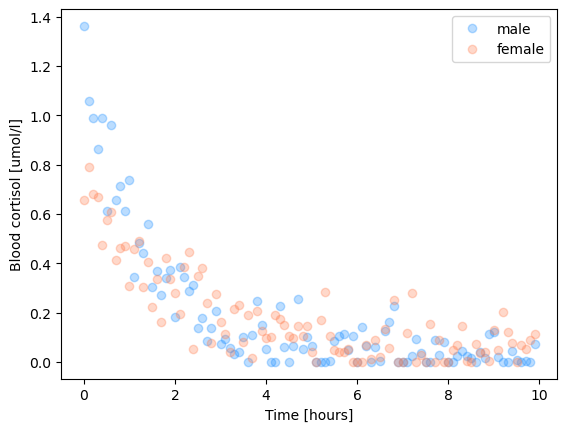

In [1]:
import numpy as np
import matplotlib.pyplot as plt

d= np.load('6.02_nonlinear_regression.npz')
x, y1, y2 = d['x'], d['y1'], d['y2']

plt.plot(x, y1, 'o', alpha=0.3, c='dodgerblue', label='male')
plt.plot(x, y2, 'o', alpha=0.3, c='coral',label='female')

plt.xlabel('Time [hours]')
plt.ylabel('Blood cortisol [umol/l]')
plt.legend()
plt.show()

In nonlinear regression, the model can be anything. We have to use biological intuition to choose the right one. Since this is a decay/removal process, we hypothesize that an exponentially decaying function should capture the relationship between time and blood cortisol:
```python
def exp_fun(x, tau, gain):
    y = gain * np.exp(-x / tau)
    return y
```
__Important:__ We have to check that assumption after fitting - if we cannot find a good fit with our data, we might have chosen the wrong function.

![](fig/6.02_nonlinear_regression_a.png)

## Error term
The error term should be:
- _strictly positive_: We want to minimize the magnitude of the error and typically do not care whether we undershoot or overshoot with our fit.
- _symmetrical_: It should reflect the difference between the prediction and the actual data, for both pos. and neg. deviations

We will here use "least-squares" curve fitting, which minimizes he mean of the squared residuals, also called the __mean-squared error (MSE)__. It is called _least squares_ fitting, because we get parameters with the "least" of the squared error.

Let $f(x_i, \theta)$ be our function (linear, exponential, quadratic), with parameters $\theta$, and $\hat{y_i} = f(x_i, \theta)$ our prediction for $N$ data points $x_i$. The MSE is then given by: $E = \sum_i^N (y_i - \hat{y_i})^2$.

## Nonlinear regression using scipy
Least-squares nonlinear regression in scipy can be done using `curve_fit`:

`res = scipy.optimize.curve_fit(fun, x, y, initial_params, bounds)` ([docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html#scipy.optimize.curve_fit))

`curve_fit` takes these arguments:
- `fun`: The "name" of the function specifying the model. But _not_ as a string! We treat the model function as a variable and pass it as an argument to the function. The model function should take the x values and parameters as arguments and return the predictions: `y_pred = fun(x, param1, param2, ...)`.
- `x` and `y`: your data.
- `initial_params`: The initial values for the function parameters as a numpy array or as a list. The order of the parameters in the list should match the order of parameters in the model function. For the exponential decay model, this would be the gain and the tau, for instance `[1.0, 10.1]`.
- `bounds` (optional): Upper and lower bounds for the values of the parameters. Restricting the range of values the parameters can come from can make fits more robust/faster (check docs for details).

`curvefit` returns a python object, holding the results with information on:
- the fitted parameters `popt` as a numpy array, in the same order as the arguments to the model function.
- their uncertainty (`pcov`)

To check how well the fitted curve reproduces our data, we can calculate the Pearson r (`scipy.stats.pearsonr`) (and its square) between the data, $y$, and the predictions generated by the model $f(x, \theta)$ with the optimal parameters $\theta$, $\hat{y}=f(x, \theta)$. See the section on _Linear Regression_ about an explanation of $r$ and $r^2$.

Let's first specify the model function:

In [2]:
# the function specifying the model
def exp_fun(x, gain, tau):
    """Exponential function

    Args:
        x (np.ndarray): Values at which the function should be evaluated.
        gain (float): Gain parameter
        tau (float): Tau parameter

    Returns:
        np.ndarray: Predictions, one for each value in x.
    """
    prediction = gain * np.exp(-x / tau)
    return prediction

print(f"{exp_fun} of type {type(exp_fun)}")

<function exp_fun at 0x116a25940> of type <class 'function'>


The starting values for the parameters can be specified as a list [gain, tau], with the values being in the same order as provided in the model function `exp_fun`:

In [3]:
gain0 = 0.1
tau0 = 1
initial_parameters = [gain0, tau0]

### Fit and print and plot

['x', 'y1', 'y2']
Fitted parameters: gain=1.18, tau=1.42
Goodness of fit: scipy.stats.pearsonr(d['y1'], y1_hat)=PearsonRResult(statistic=0.9591807717734652, pvalue=1.4688167897240502e-55)
Fitted parameters: gain=0.66, tau=2.57
Goodness of fit: scipy.stats.pearsonr(d['y2'], y2_hat)=PearsonRResult(statistic=0.8909026693033378, pvalue=2.3117926262444119e-35)


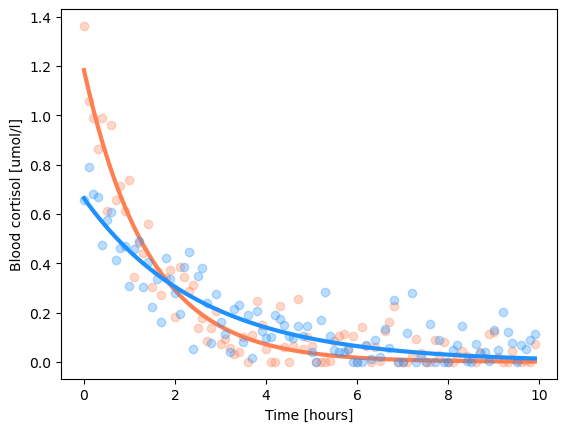

In [4]:
import scipy.optimize

d = np.load('6.02_nonlinear_regression.npz')
print(list(d.keys()))

# first, fit for y1, the male data
popt, pcov = scipy.optimize.curve_fit(exp_fun, d['x'], d['y1'], initial_parameters)
print(f"Fitted parameters: gain={popt[0]:1.2f}, tau={popt[1]:1.2f}")

y1_hat = exp_fun(d['x'], *popt)  # generate the predictions

print(f"Goodness of fit: {scipy.stats.pearsonr(d['y1'], y1_hat)=}")

plt.plot(d['x'], d['y1'], 'o', c='coral', alpha=0.3)
plt.plot(d['x'], y1_hat, c='coral', linewidth=3)


# second, fit for y2, the female data
popt, pcov = scipy.optimize.curve_fit(exp_fun, d['x'], d['y2'], initial_parameters)
print(f"Fitted parameters: gain={popt[0]:1.2f}, tau={popt[1]:1.2f}")

y2_hat = exp_fun(d['x'], *popt)  # generate the predictions

print(f"Goodness of fit: {scipy.stats.pearsonr(d['y2'], y2_hat)=}")

plt.plot(d['x'], d['y2'], 'o', c='dodgerblue', alpha=0.3)
plt.plot(d['x'], y2_hat, c='dodgerblue', linewidth=3)

plt.xlabel('Time [hours]')
plt.ylabel('Blood cortisol [umol/l]')
plt.show()

### Optional: Specifying parameter bounds
You can make the fits more robust and faster by providing constraints in the form of upper and lower bounds for each parameter.

For instance, in our example, we wanted to model concentrations - concentrations are always positive, and hence the first data values, which are specified by the gain are also always positive - the minimal gain value should therefore be 0. In addition, the first data values are typically smaller than 10. The maximal gain value can therefore also be constrained. This allows us to bound the gain parameter between 0 and 10.

We can also constrain the decay parameter: First, we specified the function as `gain * np.exp(-x/tau)`. Since the function always decays, we want only positive tau values (neg. tau values would lead to exponentially increasing functions. The minimal tau value should therefore also be positive. We can also specify an upper bound for tau: Tau corresponds to the time it takes for the data to decay to 0.36 of its initial value. Looking at the data, we see that it is near-zero after 10 hours. 10 it therefore a safe upper bound for the tau parameter. The tau parameter is therefore also bound between 0 and 10.

But careful - if you constrain the parameter values too much, you can prevent the algorithm from finding a good solution! So always make sure that your optimal values do not "hit" your bounds. 

This is one way of specifying the bounds in for `scipy.optimize.curve_fit` - as a nested list of upper and lower values for each parameter:

In [5]:
gain_lower = 0
gain_upper = 10
tau_lower = 0
tau_upper = 100
bounds = [[gain_lower, tau_lower], [gain_upper, tau_upper]]
print(bounds)

[[0, 0], [10, 100]]


Bounds are not necessary to make fitting the example data work, but just for completeness, here is the same fit with the bounds specified:

Fitted parameters: gain=1.18, tau=1.42
Goodness of fit: scipy.stats.pearsonr(d['y1'], y1_hat)=PearsonRResult(statistic=0.9591807180011536, pvalue=1.468909708552724e-55)
Fitted parameters: gain=0.66, tau=2.57
Goodness of fit: scipy.stats.pearsonr(d['y2'], y2_hat)=PearsonRResult(statistic=0.8909023604715812, pvalue=2.3120955918755056e-35)


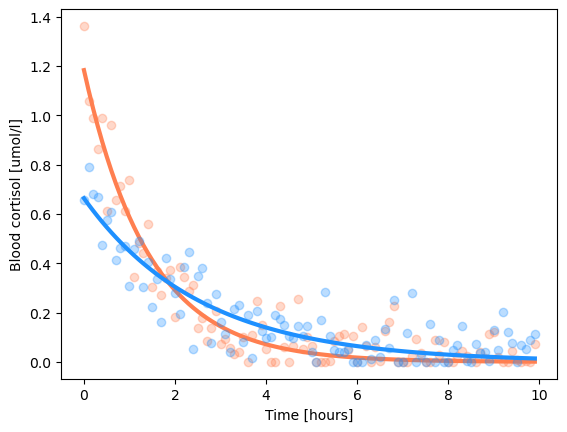

In [6]:
# first, fit for y1, the male data
popt, pcov = scipy.optimize.curve_fit(exp_fun, d['x'], d['y1'], initial_parameters, bounds=bounds)
print(f"Fitted parameters: gain={popt[0]:1.2f}, tau={popt[1]:1.2f}")

y1_hat = exp_fun(d['x'], *popt)  # generate the predictions

print(f"Goodness of fit: {scipy.stats.pearsonr(d['y1'], y1_hat)=}")

plt.plot(d['x'], d['y1'], 'o', c='coral', alpha=0.3)
plt.plot(d['x'], y1_hat, c='coral', linewidth=3)


# second, fit for y2, the female data
popt, pcov = scipy.optimize.curve_fit(exp_fun, d['x'], d['y2'], initial_parameters, bounds=bounds)
print(f"Fitted parameters: gain={popt[0]:1.2f}, tau={popt[1]:1.2f}")

y2_hat = exp_fun(d['x'], *popt)  # generate the predictions

print(f"Goodness of fit: {scipy.stats.pearsonr(d['y2'], y2_hat)=}")

plt.plot(d['x'], d['y2'], 'o', c='dodgerblue', alpha=0.3)
plt.plot(d['x'], y2_hat, c='dodgerblue', linewidth=3)

plt.xlabel('Time [hours]')
plt.ylabel('Blood cortisol [umol/l]')
plt.show()